# **Trabajo Práctico III**
___________________________________________________________________________
### *Visión Por Computadora I*                                   
### *Facultad de Ingeniería de la Universidad de Buenos Aires*
### *Laboratorios de Sistemas Embebidos*                                                 
### D. Canal, G. Schvarchman, F. Zoya

Importamos todas las bibliotecas que utilizaremos en este trabajo

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Alojamos la ruta del template en una variables ya que será de utilidad para todos los puntos del TP

In [2]:
template_url = "./template/pattern.png"

## Punto 1

### Reseña del análisis exploratorio

Luego de entender lo solocitado y los posibles caminos para poder lograr obtenerlo, comenzamos a probar con distintos modelos, generando cambios incrementales tal que en cada paso fuimos logrando obtener mejores resultados hasta obtener el algoritmo y los parámetros que nos permitieran resolver lo pedido en el primer punto del TP 3. Los pasos realiados fueron los siguientes:

**Versión 1: Matching básico con matchTemplate**

- Qué hicimos:
  - Usamos cv2.matchTemplate con una única escala y métrica cv2.TM_CCOEFF_NORMED.
  - Aplicamos un redimensionamiento del template si era más grande que la imagen para que no rompiese.

- Problemas encontrados:
  - El algoritmo fallaba cuando el logo era mucho más chico o más grande.
  - Aparecían falsos positivos en muchos casos.

**Versión 2: Evaluación con múltiples métricas**

- Qué hicimos:
  - Comparamos 6 métricas disponibles en OpenCV: TM_CCOEFF, TM_CCOEFF_NORMED, TM_CCORR, TM_CCORR_NORMED, TM_SQDIFF, TM_SQDIFF_NORMED
  - Visualizamos resultados para cada métrica en forma comparativa.

- Resultados:
  - La performance mejoró notablemente en muchas imágenes.

- Problemas encontrados:
 - Seguíamos viendo errores en varias imágenes

- Insights:
 - Algunas métricas daban resultados consistentes en ciertas imágenes pero fallaban rotundamente en otras.
 - TM_CCOEFF_NORMED demostró ser la más estable y robusta.
 - Notamos que la diferencia de escalas del logo presente en las distintas imágenes podía ser un problema.

**Versión 3: Matching multiescala del template**

- Qué hicimos:
 - Probamos 20 escalas distintas del template (con cv2.resize), manteniendo fija la imagen.
    - Rango de escalas: np.linspace(0.25, 1.0, 20).

- Resultados:
  - La performance mejoró aún más en muchas imágenes.

- Problemas encontado:
  - Continuaban apareciendo errores en muchas imágenes.

- Insights:
  - Generamos la hipótesis de que el brillo y los colores podían estar afectando el resultado.
      - Por eso decidimos buscar una representación más robusta → bordes usando Canny.


**Versión 4: Preprocesamiento con bordes (cv2.Canny)**

- Qué hicimos:
  - Aplicamos cv2.Canny tanto al template como a la imagen.
      - El objetivo fue eliminar la sensibilidad a colores, brillo e iluminación, manteniendo con la estructura del logo.

- Resultados:
  - La performance mejoró notablemente.
  - Se redujeron significativamente los falsos positivos.

- Problemas encontado:
  - Aún fallaba en algunas imágenes donde el logo era más grande que el template.

- Insights:
  - Escalar también las imágenes (y no solo el template) podría mejorar el matching.
      - Al reducir la imagen con pyrDown, el logo se achica y puede coincidir mejor con el tamaño del template.

**Versión 5: Pirámide de imagen (cv2.pyrDown)**

- Qué hicimos:
  - Aplicamos 3 niveles de reducción de la imagen con cv2.pyrDown.
  - Aplicamos matching del template (a 20 escalas) sobre cada nivel.

- Resultados:
  - Mejora en los casos que fallaban incluso usando escalas grandes.
  - Se resolvieron correctamente los casos que antes fallaban. En consecuencia, se logró una detección correcta y única del logo en todas las imágenes, sin falsos positivos.
  - La función a la cual se llegó y que permitió tales resultados tiene las siguientes características:
    - Usa la métrica TM_CCOEFF_NORMED
    - Aplica preprocesamiento con cv2.Canny
    - Evalúa sobre 20 escalas del template (0.25 → 1.0)
    - Aplica matching en 4 niveles de pirámide de la imagen (pyrDown)
    - Devuelve las coordenadas de la detección en la imagen original
    - Dibuja el bounding box con score

### Solución obtenida

Definimos algunas variables y funciones útiles para el punto 1

In [3]:
def image_url(leaf):
  return f"./images/{leaf}"

In [4]:
all_images = ["coca_logo_1.png","coca_logo_2.png","coca_multi.png","coca_retro_1.png","coca_retro_2.png","COCA-COLA-LOGO.jpg","logo_1.png"]

In [5]:
def eval_all_images(function):
  for image in all_images:
    function(template_url, image_url(image))

Modularizamos el código y delegamos responsabilidades en distintas functions para hacer más legible y sencillo de manejar

In [6]:
def build_pyramid(image, levels=3):
    pyramid = [(image, 0)]
    actual = image
    for level in range(1, levels + 1):
        actual = cv2.pyrDown(actual)
        pyramid.append((actual, level))
    return pyramid

Para la función que se presenta a continuación, inicialmente la planteamos para devolver únicamente la mejor detección, pero al avanzar con el trabajo observamos que se podía reutilizar para los siguientes puntos y, para evitar repetición de lógica innecesaria, adaptamos el método para devolver todas las detecciones y resolvimos para cada punto haciendo uso de lo que se necesitaba específicamente

In [7]:
def obtain_all_detections(template_gray, image_gray, scales, method, th1, th2,score_threshold):
    detections = []

    pyramid = build_pyramid(image_gray)

    for image_pyr , level in pyramid:
        image_canny = cv2.Canny(image_pyr, th1, th2)

        for scale in scales:
            width = int(template_gray.shape[1] * scale)
            height = int(template_gray.shape[0] * scale)
            if width < 10 or height < 10:
                continue

            template_resized = cv2.resize(template_gray, (width, height))
            template_canny = cv2.Canny(template_resized, th1, th2)

            if (template_canny.shape[0] > image_canny.shape[0] or template_canny.shape[1] > image_canny.shape[1]):
                continue

            result = cv2.matchTemplate(image_canny, template_canny, method)

            # obtenemos todas las detecciones para hacer uso en todo los puntos del TP
            h, w = template_canny.shape
            for y in range(result.shape[0]):
                for x in range(result.shape[1]):
                    score = result[y, x]
                    if score >= score_threshold:
                        detections.append({
                            "top_left": (x, y),
                            "size": (w, h),
                            "level": level,
                            "score": score
                        })

    return detections

In [8]:
def rescale_coordiantes(coord, size, level):
    factor = 2 ** level
    x, y = coord
    w, h = size
    return (x * factor, y * factor, (x + w) * factor, (y + h) * factor)

In [9]:
def draw_detection(color_image, bbox, score):
    x1, y1, x2,y2 = map(int, bbox)
    cv2.rectangle(color_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(color_image, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.6, (0, 255, 0), 4)
    plt.imshow( cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    plt.title(f"TM_CCOEFF_NORMED score={score:.2f}")
    plt.axis("off")
    plt.show()

In [10]:
def detect_unique_logo(template_path, image_path, th1=100, th2=200,score_threshold=0.15):
    scales = np.linspace(0.25, 1.0, 20)
    method = cv2.TM_CCOEFF_NORMED

    template_gray = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    color_image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

    detections = obtain_all_detections(
        template_gray, image_gray, scales, method, th1, th2, score_threshold
    )
    best_detection = max(detections, key=lambda d: d['score'])
    bbox = rescale_coordiantes(best_detection['top_left'], best_detection['size'], best_detection['level'])

    draw_detection(color_image, bbox, best_detection['score'])

    return bbox, best_detection['score']

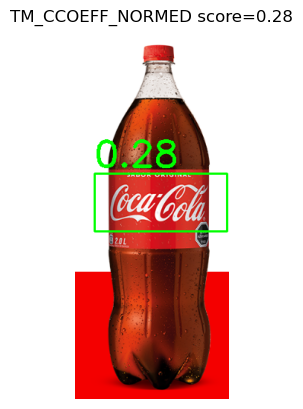

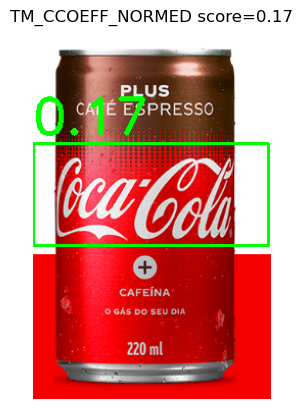

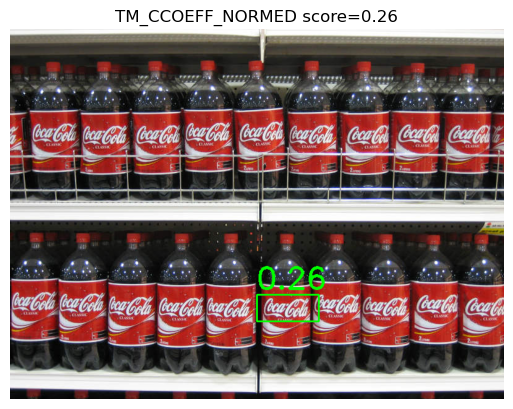

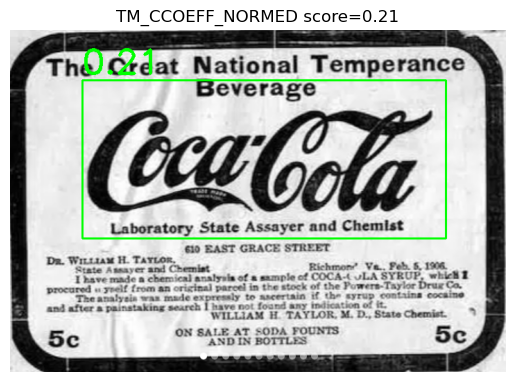

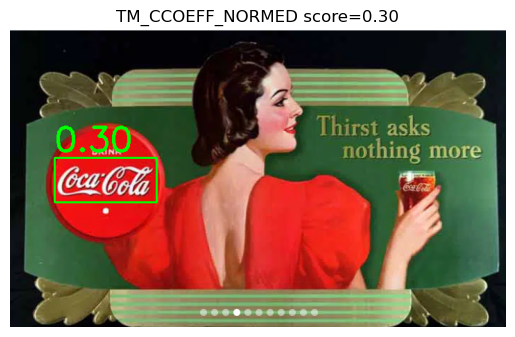

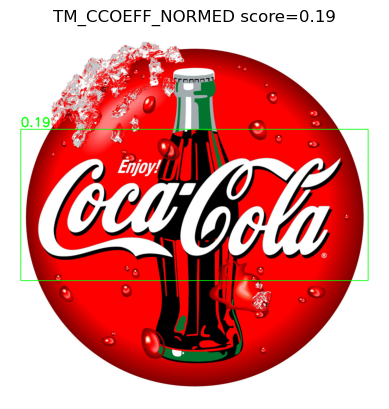

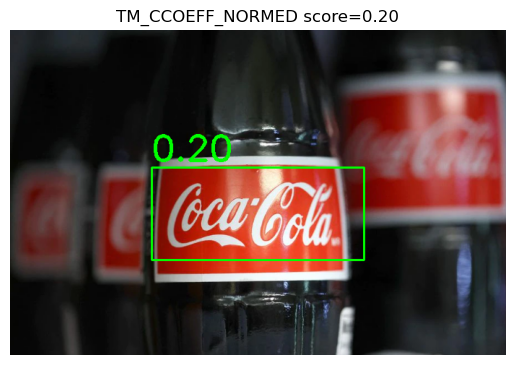

In [11]:
eval_all_images(detect_unique_logo)

## Punto 2

### Reseña del análisis exploratorio

Luego de obtener buenos resultados para detectar una única instancia del logo (Punto 1), abordamos el siguiente desafío de detectar múltiples instancias del logo dentro de una misma imagen, cumpliendo la condición de no tener duplicados ni falsos positivos. Para ello, mantuvimos la base del algoritmo anterior y fuimos realizando mejoras incrementales sobre él. A continuación, describimos las modificaciones y pruebas realizadas:

**Versión 1: Reutilización del motor de detección multiescala**

- Qué hicimos:
  - Reutilizamos el código matchTemplate multiescala y multiresolución del punto 1.
  - En lugar de quedarnos con la mejor detección, recolectamos todas las detecciones con score mayor a un cierto score_threshold.
  
- Resultado:
  - Se obtuvieron múltiples coincidencias en imágenes con varios logos.

- Problemas encontrados:
  - Muchas detecciones eran duplicadas o solapadas.
  - Aparecían múltiples boxes sobre la misma instancia del logo.

**Versión 2: Aplicación de Non-Maximum Suppression (NMS)**

- Qué hicimos:
  - Implementamos un NMS simple por distancia entre centros de bounding boxes.
  - Ordenamos las detecciones por score y eliminamos aquellas demasiado cercanas a una ya aceptada.

- Resultado:
  - Se redujeron drásticamente las detecciones redundantes.
  - Se mantuvo una única detección por instancia del logo.

- Problemas encontrados:
  - Aún persistían algunos falsos positivos en zonas no deseadas.

**Versión 3: Ajuste fino del umbral de score (score_threshold)**

- Qué hicimos:
  - Probamos distintos valores de score_threshold para balancear precisión y recall.
  - Identificamos un punto óptimo de 0.16 para la muestra de fotos tabajada.

- Problemas encontrados:
  - Si el umbral era muy bajo: se generaban falsos positivos.
  - Si era muy alto: se perdían instancias válidas (falsos negativos).

### Solución obtenida

In [12]:
def filter_similar_detections(detections, min_dist=20):
    selected = []
    for detection in sorted(detections, key=lambda x: -x['score']):
        x1, y1 = detection['top_left']
        width, height = detection['size']
        cx1, cy1 = x1 + width // 2, y1 +height // 2
        level = detection['level']
        too_close = False
        for sel in selected:
            x2, y2 = sel['top_left']
            width2, height2 = sel['size']
            cx2, cy2 = x2 + width2 // 2, y2 +height2 // 2
            if detection['level'] == sel['level']:
                dist = np.hypot(cx2 - cx1, cy2 - cy1)
                if dist < min_dist:
                    too_close = True
                    break
        if not too_close:
            selected.append(detection)
    return selected

In [13]:
def draw_multiple_detections(color_image, detections):
    for det in detections:
        x1, y1, x2, y2 = rescale_coordiantes(det['top_left'], det['size'], det['level'])
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cv2.rectangle(color_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(color_image, f"{det['score']:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 3)
        cv2.putText(color_image, f"{det['score']:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Min TM_CCOEFF_NORMED score={det['score']:.2f}")
    plt.axis("off")
    plt.show()

In [14]:
def detect_multiple_logos(template_path, image_path, th1=100, th2=200, score_threshold=0.16):
    scales = np.linspace(0.25, 1.0, 20)
    method = cv2.TM_CCOEFF_NORMED

    template_gray = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    color_image = cv2.imread(image_path)
    imagen_gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

    detections = obtain_all_detections(template_gray, imagen_gray, scales, method, th1, th2, score_threshold)

    filtered_detections = filter_similar_detections(detections)
    draw_multiple_detections(color_image, filtered_detections)

    return filtered_detections


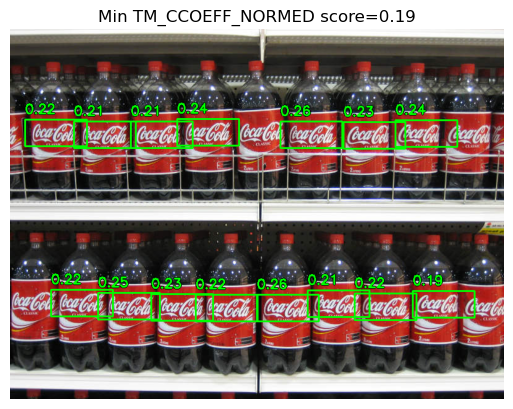

[{'top_left': (399, 429),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.2620494)},
 {'top_left': (437, 149),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.26025543)},
 {'top_left': (142, 426),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.2491321)},
 {'top_left': (623, 147),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.23858795)},
 {'top_left': (270, 145),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.2381108)},
 {'top_left': (228, 428),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.22846253)},
 {'top_left': (539, 150),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.22762749)},
 {'top_left': (300, 429),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.22473769)},
 {'top_left': (24, 146),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.22365762)},
 {'top_left': (557, 427),
  'size': (100, 43),
  'level': 0,
  'score': np.float32(0.22252114)},
 {'top_left': (66, 421),
  'size':

In [15]:
detect_multiple_logos(template_url,image_url("coca_multi.png"))

## Punto 3

### Reseña del análisis exploratorio

Para el punto 3, más allá de construir un algoritmo independiente y único, reutilizamos la funciones realizadas previamente para evitar la repetición de lógica, ya que el algoritmo final resultó una extensión del modelo realizado en el punto 2. En ese sentido:

1. Se mantuvo el motor de detección por matchTemplate con:
  - Múltiples escalas del template.
  - Pirámide de imágenes para permitir detecciones proporcionales.

2. Se mantuvo el uso de cv2.TM_CCOEFF_NORMED como métrica de matching.

3. Se utilizó Non-Maximum Suppression (NMS) por distancia para evitar detecciones redundantes.

4. Se filtraron detecciones por score absoluto (score_threshold)

**Versión 1: Score relativo respecto al mejor match**

- Qué hicimos:
  - Incorporamos un filtro adicional que consideraba válidas solo aquellas detecciones cuyo score fuera al menos un porcentaje del mejor score obtenido en la imagen.
    - Esto nos permitió aplicar un filtro más dinámico, adaptado a cada imagen.

- Problemas encontrados:
  - Al bajar demasiado este umbral relativo, aparecían falsos positivos.
  - Si se subía, se perdían muchas instancias verdaderas en imágenes con múltiples logos.

- Insight:
  - Este criterio no era suficiente por sí solo, y necesitaba una segunda capa de validación estructural.

**Versión 2: Validación por estructura (bordes de Canny)**

- Qué hicimos:
  - Incorporamos una validación adicional basada en la cantidad de bordes presentes en cada detección.
    - Para ello, comparamos la cantidad de bordes obtenidos con Canny en el parche detectado contra la cantidad de bordes del template original.
    - Solo se aceptaron detecciones que tuvieran al menos un porcentaje de los bordes del template. Se observó que 0.7 fue el procentaje que permitió obtener un resultado óptimo.

- Resultado:
  - Se eliminaron eficazmente falsos positivos en regiones sin estructura.
  - Se pudo reducir el umbral de similarity_to_best, aumentando el recall sin sacrificar precisión.

### Solución obtenida

In [16]:
def valdiate_borders_vs_template(patch_gray, border_template,canny_th1=100, canny_th2=200,min_border_percentage=0.7):
    border_patch = cv2.Canny(patch_gray, canny_th1, canny_th2)
    patch_amount = np.sum(border_patch > 0)
    return patch_amount >= min_border_percentage * border_template

In [17]:
def detect_relevant_multiple_logos(template_path, image_path,th1=100, th2=200, score_threshold=0.15, similarity_to_best=0.8, min_border_percentage=0.2):

    scales = np.linspace(0.25, 1.0, 20)
    method = cv2.TM_CCOEFF_NORMED

    template_gray = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
    color_image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

    template_edges = cv2.Canny(template_gray, th1, th2)
    border_template = np.sum(template_edges > 0)

    detections = obtain_all_detections(template_gray, image_gray, scales, method, th1, th2, score_threshold)
    if not detections:
        return []

    best = max(detections, key=lambda d: d['score'])
    best_score = best['score']
    relative_threshold = best_score * similarity_to_best

    filtered_detections = filter_similar_detections(detections)

    final_detections = []
    for d in filtered_detections:
        if d['score'] >= relative_threshold or d == best:
            x1, y1, x2, y2 = map(int, rescale_coordiantes(d['top_left'], d['size'], d['level']))
            patch = image_gray[y1:y2, x1:x2]
            if patch.shape[0] > 0 and patch.shape[1] > 0:
                if valdiate_borders_vs_template(patch, border_template, canny_th1=th1, canny_th2=th2, min_border_percentage=min_border_percentage):
                    final_detections.append(d)

    draw_multiple_detections(color_image, final_detections)

    return final_detections

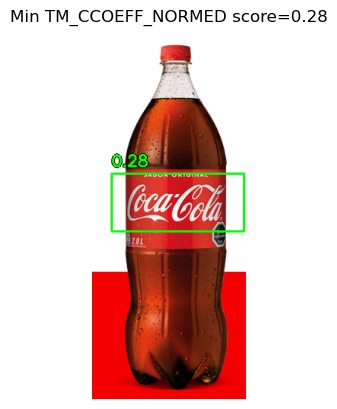

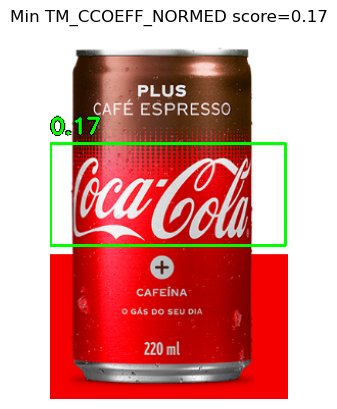

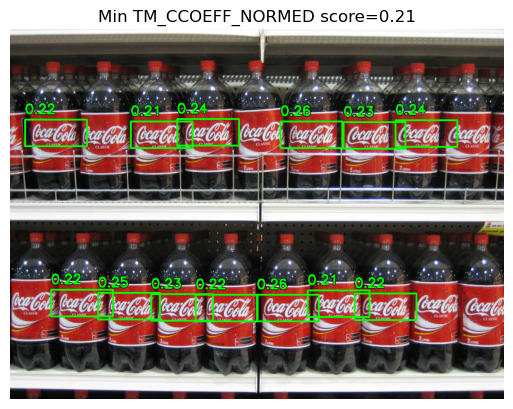

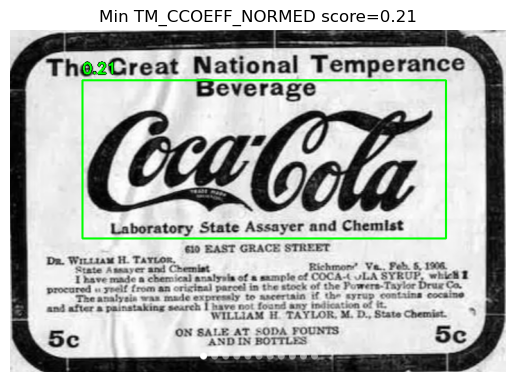

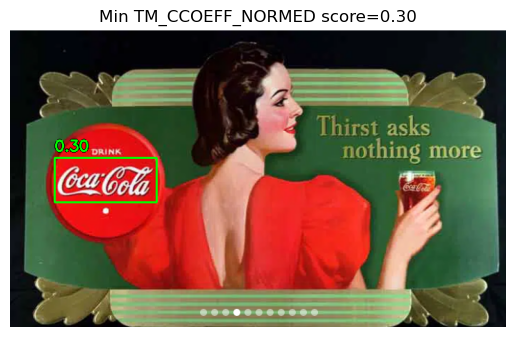

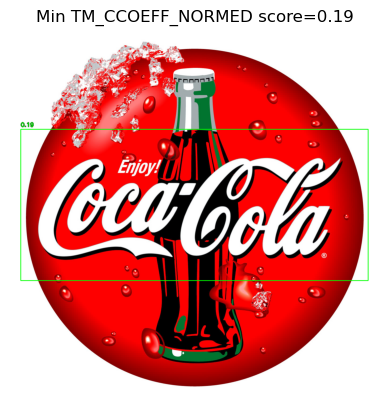

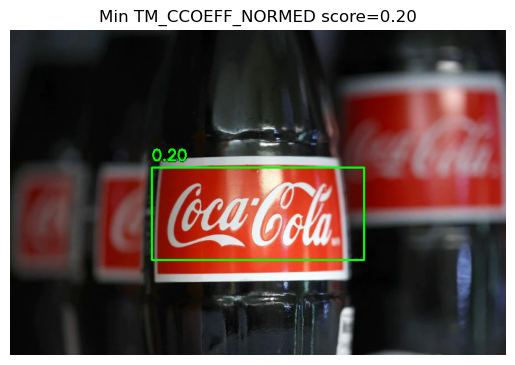

In [18]:
eval_all_images(detect_relevant_multiple_logos)

**Resultado final**

Se obtuvo un único algoritmo que, sin necesidad de cambiar su configuración, es capaz de:
  - Detectar correctamente una única instancia del logo cuando hay una sola.
  - Detectar correctamente múltiples instancias, sin falsos positivos ni duplicados.